In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt



2024-05-27 21:19:55.419546: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 21:19:57.227969: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Cargar el dataset desde el archivo CSV
path = "dataset/divvy_daily.csv"
df = pd.read_csv(path)

In [3]:
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df = df.set_index('date')
lstm_df = df.drop(columns = ['temperature', 'weather'])

In [4]:
lstm_df

,rides
date,
2014-01-01,95
2014-01-02,111
2014-01-03,6
2014-01-04,181
2014-01-05,32
...,...
2017-12-27,1117
2017-12-28,1267
2017-12-29,1049


In [5]:
# Dividir los datos en entrenamiento y prueba
train_size = int(len(lstm_df) * 0.8)
test_size = len(lstm_df) - train_size
train_data, test_data = lstm_df.iloc[0:train_size], lstm_df.iloc[train_size:len(lstm_df)]


In [6]:
# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)


In [7]:
# Crear el conjunto de datos para entrenamiento
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)


In [8]:
time_step = 10
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)


In [9]:
# Reshape de los datos para [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [10]:
# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')



/home/juanperdomo/forecasting-divvy-bike-rides/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=1)

# Hacer predicciones
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

Epoch 1/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0959
Epoch 2/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0275
Epoch 3/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0243
Epoch 4/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0222
Epoch 5/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0237
Epoch 6/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0214
Epoch 7/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0228
Epoch 8/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0236
Epoch 9/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0217
Epoch 10/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0240
Epoch 11/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0213
Epoch 12/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0232
Epoch 13/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0208
Epoch 14/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0206
Epoch 15/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - lo

In [12]:
# Invertir la escala de las predicciones
train_predict = scaler.inverse_transform(train_predict)
y_train_true = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))

In [13]:
# Calcular MAPE para el conjunto de prueba
mape = mean_absolute_percentage_error(y_test_true, test_predict)
print(f'MAPE: {mape:.4f}')

MAPE: 0.3443


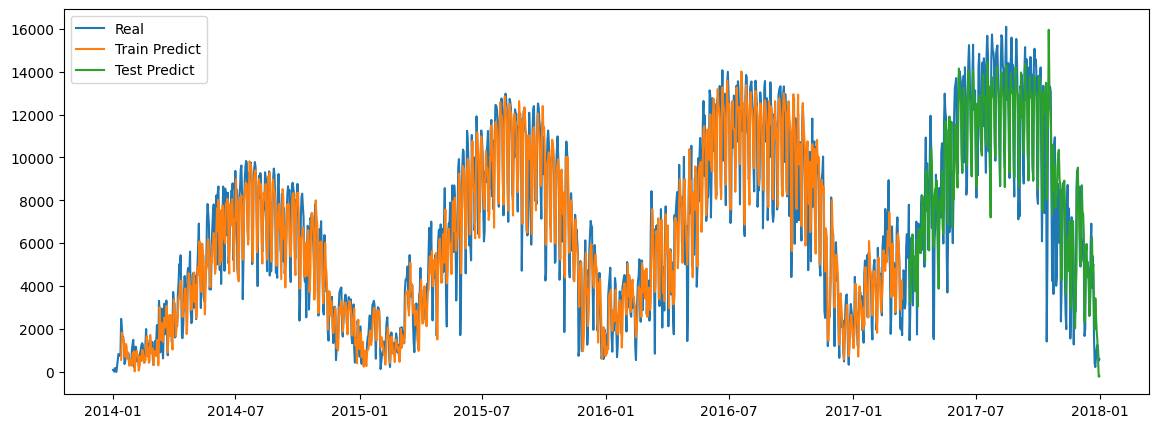

In [14]:
# Visualizar los resultados
plt.figure(figsize=(14, 5))

# Ajustar los índices para los valores reales y las predicciones
train_predict_plot = np.empty_like(np.concatenate((train_scaled, test_scaled), axis=0))
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict

test_predict_plot = np.empty_like(np.concatenate((train_scaled, test_scaled), axis=0))
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2):len(lstm_df), :] = test_predict

plt.plot(lstm_df.index, scaler.inverse_transform(np.concatenate((train_scaled, test_scaled), axis=0)), label='Real')
plt.plot(lstm_df.index, train_predict_plot, label='Train Predict')
plt.plot(lstm_df.index, test_predict_plot, label='Test Predict')
plt.legend()
plt.show()

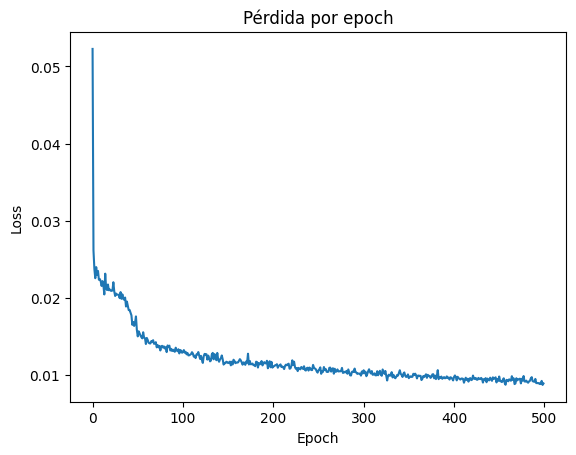

In [15]:
loss_per_epoch = history.history['loss']

plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pérdida por epoch')
plt.show()